In [1]:
# File for Carlos Grandet and Hector Salvador
import scipy.io
import matplotlib.pyplot as plt
from pyspark import SparkContext
from pyspark.ml.linalg import Vectors
from pyspark.sql import SparkSession
import random
from sklearn import linear_model
from sklearn.preprocessing import normalize
import numpy as np
import time
import math

%matplotlib inline 

sparse_file = "../../project/cmsc25025/sparsecoding/IMAGES_RAW.mat"  #Working directory/file

In [2]:
spark = SparkSession.builder.master('local[10]').appName('review').getOrCreate()

In [3]:
# Initialize a SparkContext
sc = spark.sparkContext

In [6]:
# Read the data
data = scipy.io.loadmat(sparse_file)

In [7]:
# images is a 3D array of size [512, 512, 10]
images = data['IMAGESr']
images.shape

(512, 512, 10)

In [8]:
def plot_fig(fig_array, size):
    plt.figure(figsize=(size, size))
    plt.imshow(fig_array, cmap='gray')
    plt.axis('off')

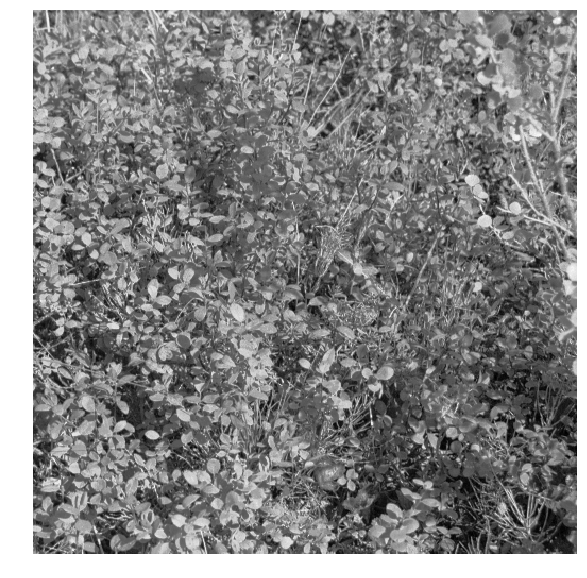

In [9]:
# Let's look at a sample image with this!
test_image = images[:,:,4]
image_size = 10
plot_fig(test_image, image_size)

In [10]:
def sample_random_square_patches(image, num, width):
    patches = np.zeros([width, width, num])
    for k in range(num):
        i, j = random.sample(range(image.shape[0] - width), 2)
        patches[:,:,k] = image[i:i + width, j:j + width]
    return patches

## Playing around

In [11]:
# How big do we want our patches to be? How many patches?
# Let's define, for now the following:
patch_width = 12
patch_nums = 50

In [12]:
# Let's create a sample now
test_image = images[:,:,3]
patches = sample_random_square_patches(test_image, patch_nums, patch_width)
patches.shape

(12, 12, 50)

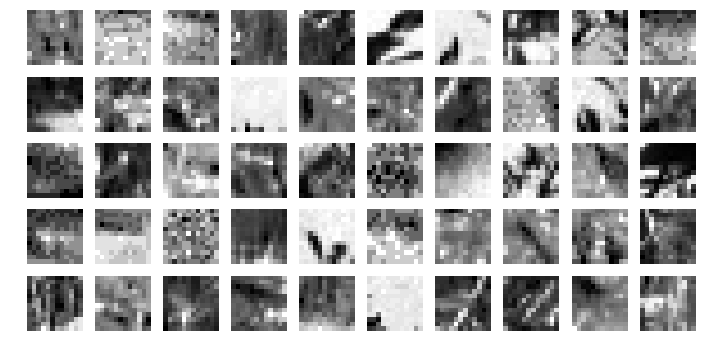

In [13]:
# And let's visualize some of the sample y(i)'s
plt.figure(figsize=(12,12))
for i in range(patches.shape[2]):
    plt.subplot(10, 10, i + 1)
    plt.imshow(patches[:,:,i], cmap='gray')
    plt.axis("off")

In [14]:
# So, given that our patches are squares of width 12, we will have y(i) vectors of length 12x12=144
# Let's initialize a random dictionary of entries with p vectors.
# Using the minimum and maximum values in images, let's create random numbers in the same space as our
# original pictures.

# n is the same dimension as the y(i) vectors, so 144
n = 144

p = 300 # Let's try 300 for now, maybe we can change this later, remember p >> n

# Randomly create a matrix 
basis = np.random.rand(n, p)
print(basis.shape)
basis

(144, 300)


array([[ 0.29164879,  0.21043975,  0.92331847, ...,  0.13280123,
         0.29873396,  0.30675788],
       [ 0.44995398,  0.56950588,  0.65232542, ...,  0.05368807,
         0.85271623,  0.76425322],
       [ 0.33675705,  0.06361107,  0.07466143, ...,  0.9277214 ,
         0.04845998,  0.49910214],
       ..., 
       [ 0.148628  ,  0.60510523,  0.54799688, ...,  0.63997195,
         0.18790958,  0.53524205],
       [ 0.03868478,  0.4698637 ,  0.62274094, ...,  0.45487915,
         0.72509333,  0.95544675],
       [ 0.39367649,  0.00586561,  0.54626778, ...,  0.00416216,
         0.0990029 ,  0.21189929]])

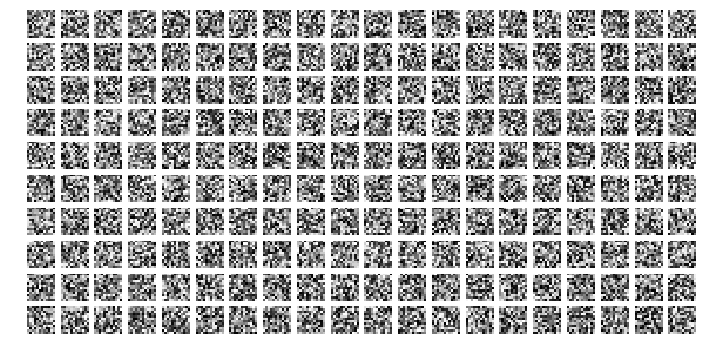

In [15]:
plt.figure(figsize=(12,12))
for i in range(200):
    plt.subplot(20, 20, i + 1)
    plt.imshow(basis[:,i].reshape(12,12), cmap='gray')
    plt.axis("off")

In [16]:
# now, since my images are matrices, we need to flatten them: 
flat_patches = [patches[:,:,i].reshape(-1,) for i in range(patches.shape[2])]
np.array(flat_patches).shape

(50, 144)

In [17]:
# Which could be a sensible number for alpha?
checks = []
for i in range(500):
    #now = time.time()
    regr = linear_model.ElasticNet(alpha= (i+1.0)/10000.0, l1_ratio=1) # l1_ratio=1 is Lasso, l1_ratio=0 adds L2 penalty
    r = regr.fit(basis, flat_patches[0])
    #time.time() - now
    print(i, (i+1.0)/10000.0, r.coef_.sum(), ((r.predict(basis)-flat_patches[0]) ** 2).mean(axis=0))

/software/python-2.7.12-el7-x86_64/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


(0, 0.0001, 0.48777152020706716, 3.2459426502866006e-05)
(1, 0.0002, 0.23986369196803492, 0.00012313344025686998)
(2, 0.0003, 0.21976757755691029, 0.000265548299836085)
(3, 0.0004, 0.21258349539908236, 0.00046583217928988709)
(4, 0.0005, 0.3493882844283549, 0.00070811694034520162)
(5, 0.0006, 0.38676515587085786, 0.00097887165515792365)
(6, 0.0007, 0.40008653454391158, 0.0012956381128753718)
(7, 0.0008, 0.41001202213026006, 0.0016499678319105682)
(8, 0.0009, 0.4319670633242263, 0.0020464046800464084)
(9, 0.001, 0.44077392407865679, 0.0024747256676710357)
(10, 0.0011, 0.44032676962032286, 0.0029450089066845719)
(11, 0.0012, 0.42852564094771517, 0.003446002540049474)
(12, 0.0013, 0.4314772450060933, 0.0039849769260408563)
(13, 0.0014, 0.42264916334090497, 0.0045559879538097248)
(14, 0.0015, 0.40679010935277204, 0.0051526062901641433)
(15, 0.0016, 0.39734473902291967, 0.0057741772067733156)
(16, 0.0017, 0.35850550634272865, 0.0064196474447285627)
(17, 0.0018, 0.31650171878986544, 0.007111

In [18]:
regr = linear_model.Lasso(alpha = 0.01)
regs = np.array([regr.fit(basis, patch) for patch in flat_patches])
betas = np.array([r.coef_ for r in regs])
preds = np.array([r.predict(basis) for r in regs])
grad = np.array(preds - np.array(flat_patches)).T.dot(betas)
basis_new = basis - grad * 0.01
basis_new = normalize(basis_new, norm='l1', axis=0)

In [19]:
betas.sum()

18.618206854278526

In [20]:
preds

array([[-0.52728191, -0.65333543, -0.10137107, ...,  0.01640933,
        -0.16675912, -0.11382241],
       [-0.52728191, -0.65333543, -0.10137107, ...,  0.01640933,
        -0.16675912, -0.11382241],
       [-0.52728191, -0.65333543, -0.10137107, ...,  0.01640933,
        -0.16675912, -0.11382241],
       ..., 
       [-0.52728191, -0.65333543, -0.10137107, ...,  0.01640933,
        -0.16675912, -0.11382241],
       [-0.52728191, -0.65333543, -0.10137107, ...,  0.01640933,
        -0.16675912, -0.11382241],
       [-0.52728191, -0.65333543, -0.10137107, ...,  0.01640933,
        -0.16675912, -0.11382241]])

In [21]:
grad.sum()

-677.70142746983947

In [22]:
print(basis_new.shape)
basis_new

(144, 300)


array([[  4.29073695e-03,   2.87391682e-03,   1.19877247e-02, ...,
          1.84371687e-03,   3.96074017e-03,   4.23566639e-03],
       [  6.40800049e-03,   7.77758274e-03,   8.46933956e-03, ...,
          7.45366586e-04,   1.13056696e-02,   1.05526929e-02],
       [  4.53480181e-03,   8.68718672e-04,   9.69352030e-04, ...,
          1.28798170e-02,   6.42502759e-04,   6.89152691e-03],
       ..., 
       [  2.08013138e-03,   8.26375310e-03,   7.11481033e-03, ...,
          8.88491055e-03,   2.49138406e-03,   7.39054123e-03],
       [  7.29654588e-04,   6.41679737e-03,   8.08523521e-03, ...,
          6.31521512e-03,   9.61359168e-03,   1.31926642e-02],
       [  5.31833671e-03,   8.01049664e-05,   7.09236083e-03, ...,
          5.77844000e-05,   1.31262200e-03,   2.92587341e-03]])

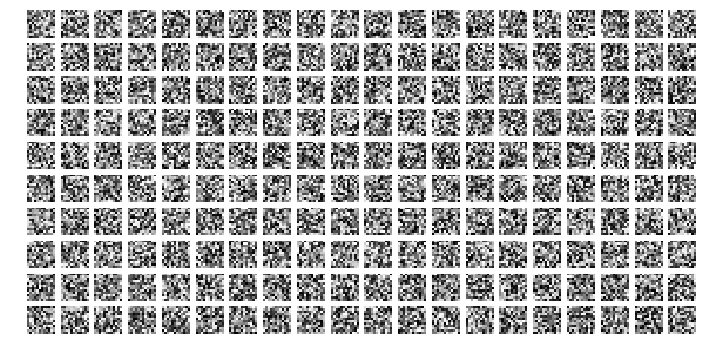

In [23]:
plt.figure(figsize=(12,12))
for i in range(200):
    plt.subplot(20, 20, i + 1)
    plt.imshow(basis_new[:,i].reshape(12,12), cmap='gray')
    plt.axis("off")

#### Second iteration

In [24]:
# Get new patches
test_image = images[:,:,random.randint(0,9)]
patches = sample_random_square_patches(test_image, patch_nums, patch_width)
flat_patches = [patches[:,:,i].reshape(-1,) for i in range(patches.shape[2])]

In [25]:
#regr = linear_model.ElasticNet(alpha=0.01, l1_ratio=0.9)
regs = np.array([linear_model.ElasticNet(alpha=0.0005, l1_ratio=1).fit(basis_new, patch) for patch in flat_patches])

In [26]:
betas = np.array([r.coef_ for r in regs])
print(betas.sum())
betas

4.79970743031


array([[ 0.,  0.,  0., ..., -0., -0., -0.],
       [-0.,  0.,  0., ..., -0., -0.,  0.],
       [ 0.,  0.,  0., ..., -0.,  0., -0.],
       ..., 
       [ 0., -0.,  0., ..., -0., -0., -0.],
       [-0.,  0.,  0., ...,  0.,  0.,  0.],
       [-0., -0.,  0., ...,  0., -0.,  0.]])

In [27]:
preds = np.array([r.predict(basis_new) for r in regs])
preds

array([[-0.33283568, -0.33283568, -0.33283568, ..., -0.33283568,
        -0.33283568, -0.33283568],
       [ 0.48915446,  0.48915446,  0.48915446, ...,  0.48915446,
         0.48915446,  0.48915446],
       [ 0.10101835,  0.10101835,  0.10101835, ...,  0.10101835,
         0.10101835,  0.10101835],
       ..., 
       [ 1.13903541,  1.13903541,  1.13903541, ...,  1.13903541,
         1.13903541,  1.13903541],
       [ 1.09394983,  1.09394983,  1.09394983, ...,  1.09394983,
         1.09394983,  1.09394983],
       [-0.18893643, -0.18893643, -0.18893643, ..., -0.18893643,
        -0.18893643, -0.18893643]])

In [28]:
grad = np.array(preds - np.array(flat_patches)).T.dot(betas)
basis_new = basis_new - grad * 0.01
print(basis_new.shape)

(144, 300)


In [29]:
basis_new = normalize(basis_new, norm='l1', axis=0)

In [30]:
print(basis_new.shape)
basis_new

(144, 300)


array([[  4.29073695e-03,   2.87391682e-03,   1.19877247e-02, ...,
          1.84371687e-03,   3.96074017e-03,   4.23566639e-03],
       [  6.40800049e-03,   7.77758274e-03,   8.46933956e-03, ...,
          7.45366586e-04,   1.13056696e-02,   1.05526929e-02],
       [  4.53480181e-03,   8.68718672e-04,   9.69352030e-04, ...,
          1.28798170e-02,   6.42502759e-04,   6.89152691e-03],
       ..., 
       [  2.08013138e-03,   8.26375310e-03,   7.11481033e-03, ...,
          8.88491055e-03,   2.49138406e-03,   7.39054123e-03],
       [  7.29654588e-04,   6.41679737e-03,   8.08523521e-03, ...,
          6.31521512e-03,   9.61359168e-03,   1.31926642e-02],
       [  5.31833671e-03,   8.01049664e-05,   7.09236083e-03, ...,
          5.77844000e-05,   1.31262200e-03,   2.92587341e-03]])

After 2 iterations.


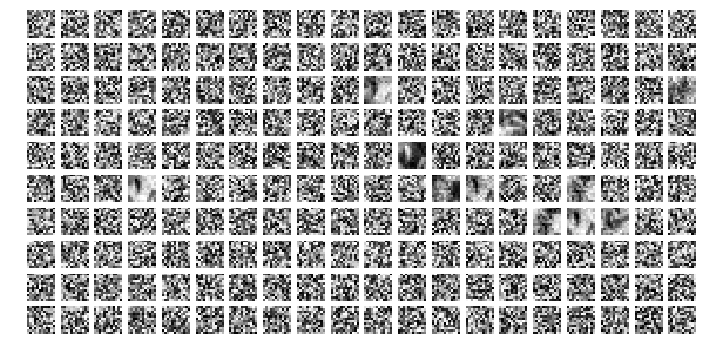

In [31]:
print("After 2 iterations.")
plt.figure(figsize=(12,12))
for i in range(200):
    plt.subplot(20, 20, i + 1)
    plt.imshow(basis_new[:,i].reshape(12,12), cmap='gray')
    plt.axis("off")

#### Third iteration

In [32]:
# Get new patches
test_image = images[:,:,random.randint(0,9)]
patches = sample_random_square_patches(test_image, patch_nums, patch_width)
flat_patches = [patches[:,:,i].reshape(-1,) for i in range(patches.shape[2])]

In [33]:
regs = np.array([linear_model.ElasticNet(alpha=0.001, l1_ratio=1).fit(basis_new, patch) for patch in flat_patches])

In [34]:
betas = np.array([r.coef_ for r in regs])
print(betas.sum())
betas

-41.0466213471


array([[ 0.,  0., -0., ..., -0., -0.,  0.],
       [-0., -0., -0., ...,  0.,  0., -0.],
       [-0., -0.,  0., ..., -0.,  0., -0.],
       ..., 
       [ 0.,  0., -0., ...,  0., -0.,  0.],
       [ 0., -0., -0., ..., -0., -0., -0.],
       [ 0.,  0.,  0., ...,  0., -0., -0.]])

In [35]:
preds = np.array([r.predict(basis_new) for r in regs])
grad = np.array(preds - np.array(flat_patches)).T.dot(betas)
basis_new = basis_new - grad * 0.01
basis_new = normalize(basis_new, norm='l1', axis=0)

After 3 iterations.


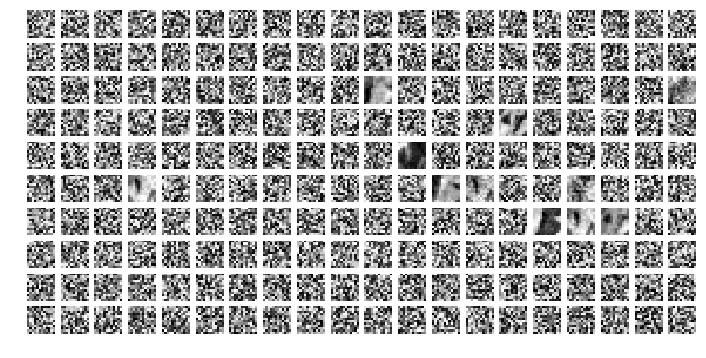

In [36]:
print("After 3 iterations.")
plt.figure(figsize=(12,12))
for i in range(200):
    plt.subplot(20, 20, i + 1)
    plt.imshow(basis_new[:,i].reshape(12,12), cmap='gray')
    plt.axis("off")

#### After 4 iterations?

In [37]:
# Get new patches
test_image = images[:,:,random.randint(0,9)]
patches = sample_random_square_patches(test_image, patch_nums, patch_width)
flat_patches = [patches[:,:,i].reshape(-1,) for i in range(patches.shape[2])]

In [38]:
regs = np.array([linear_model.ElasticNet(alpha=0.001, l1_ratio=1).fit(basis_new, patch) for patch in flat_patches])
betas = np.array([r.coef_ for r in regs])
print(betas.sum())
betas

82.935762593


array([[-0., -0.,  0., ..., -0.,  0.,  0.],
       [ 0.,  0.,  0., ..., -0., -0.,  0.],
       [-0., -0.,  0., ..., -0.,  0., -0.],
       ..., 
       [-0.,  0., -0., ...,  0., -0.,  0.],
       [ 0., -0.,  0., ..., -0., -0.,  0.],
       [-0.,  0.,  0., ..., -0.,  0.,  0.]])

In [39]:
preds = np.array([r.predict(basis_new) for r in regs])
grad = np.array(preds - np.array(flat_patches)).T.dot(betas)
basis_new = basis_new - grad * 0.01
basis_new = normalize(basis_new, norm='l1', axis=0)

After 4 iterations.


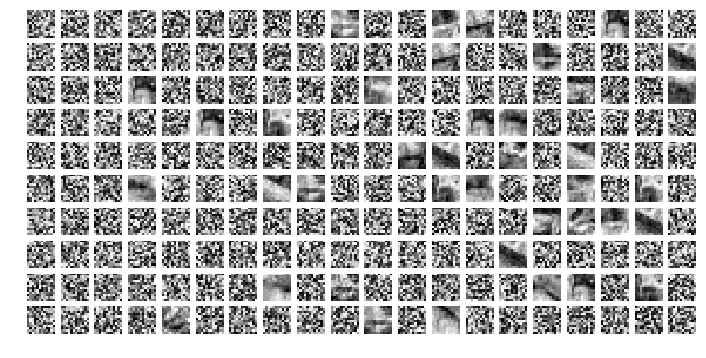

In [40]:
print("After 4 iterations.")
plt.figure(figsize=(12,12))
for i in range(200):
    plt.subplot(20, 20, i + 1)
    plt.imshow(basis_new[:,i].reshape(12,12), cmap='gray')
    plt.axis("off")

### Let's do now maybe 20?

In [41]:
# Alpha choice really matters, we tried 0.1, 0.01, 0.001 and ended up with 0.0001
for it in range(20):
    test_image = images[:,:,random.randint(0,9)]
    patches = sample_random_square_patches(test_image, patch_nums, patch_width)
    flat_patches = [patches[:,:,i].reshape(-1,) for i in range(patches.shape[2])]
    regs = np.array([linear_model.ElasticNet(alpha=0.0005, l1_ratio=1).fit(basis_new, patch) for patch in flat_patches])
    betas = np.array([r.coef_ for r in regs])
    preds = np.array([r.predict(basis_new) for r in regs])
    grad = np.array(preds - np.array(flat_patches)).T.dot(betas)
    basis_new = basis_new - grad * 0.01
    basis_new = normalize(basis_new, norm='l1', axis=0)

After 24 iterations.


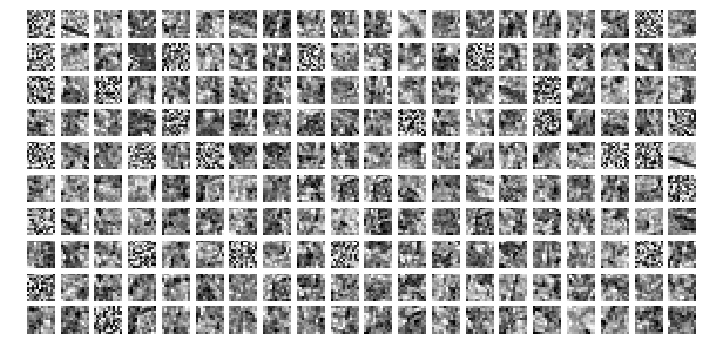

In [42]:
print("After 24 iterations.")
plt.figure(figsize=(12,12))
for i in range(200):
    plt.subplot(20, 20, i + 1)
    plt.imshow(basis_new[:,i].reshape(12,12), cmap='gray')
    plt.axis("off")

In [43]:
basis_new

array([[  4.29073695e-03,   4.94753586e-03,  -5.36594626e-03, ...,
          1.84371687e-03,  -3.04605894e-03,  -1.57265055e-02],
       [  6.40800049e-03,   3.45369890e-03,  -1.08203508e-02, ...,
          7.45366586e-04,  -3.10353417e-03,   4.38212344e-04],
       [  4.53480181e-03,  -2.79732574e-03,  -1.02728951e-02, ...,
          1.28798170e-02,   1.38055358e-03,  -1.22344066e-02],
       ..., 
       [  2.08013138e-03,   1.11276060e-02,   9.10800094e-03, ...,
          8.88491055e-03,   3.69206740e-03,  -2.86875004e-03],
       [  7.29654588e-04,   8.10389689e-03,  -3.03779863e-04, ...,
          6.31521512e-03,  -1.15464184e-03,   1.01019594e-03],
       [  5.31833671e-03,  -1.62333906e-03,   2.89759586e-03, ...,
          5.77844000e-05,   8.75053342e-03,   1.71709980e-03]])

In [44]:
t = basis_new.copy()

# Now, let's test

In [45]:
basis_new = t.copy()

In [46]:
basis_new

array([[  4.29073695e-03,   4.94753586e-03,  -5.36594626e-03, ...,
          1.84371687e-03,  -3.04605894e-03,  -1.57265055e-02],
       [  6.40800049e-03,   3.45369890e-03,  -1.08203508e-02, ...,
          7.45366586e-04,  -3.10353417e-03,   4.38212344e-04],
       [  4.53480181e-03,  -2.79732574e-03,  -1.02728951e-02, ...,
          1.28798170e-02,   1.38055358e-03,  -1.22344066e-02],
       ..., 
       [  2.08013138e-03,   1.11276060e-02,   9.10800094e-03, ...,
          8.88491055e-03,   3.69206740e-03,  -2.86875004e-03],
       [  7.29654588e-04,   8.10389689e-03,  -3.03779863e-04, ...,
          6.31521512e-03,  -1.15464184e-03,   1.01019594e-03],
       [  5.31833671e-03,  -1.62333906e-03,   2.89759586e-03, ...,
          5.77844000e-05,   8.75053342e-03,   1.71709980e-03]])

#### A thousand?

In [47]:
# We also adjusted the eta to be = 1/stepnumber
for it in range(500):
    test_image = images[:,:,random.randint(0,9)]
    patches = sample_random_square_patches(test_image, patch_nums, patch_width)
    flat_patches = [patches[:,:,i].reshape(-1,) for i in range(patches.shape[2])]
    regs = np.array([linear_model.ElasticNet(alpha=0.0005, l1_ratio=1).fit(basis_new, patch) for patch in flat_patches])
    betas = np.array([r.coef_ for r in regs])
    preds = np.array([r.predict(basis_new) for r in regs])
    grad = np.array(preds - np.array(flat_patches)).T.dot(betas)
    basis_new = basis_new - grad * 0.01
    basis_new = normalize(basis_new, norm='l1', axis=0)

After 524 iterations.


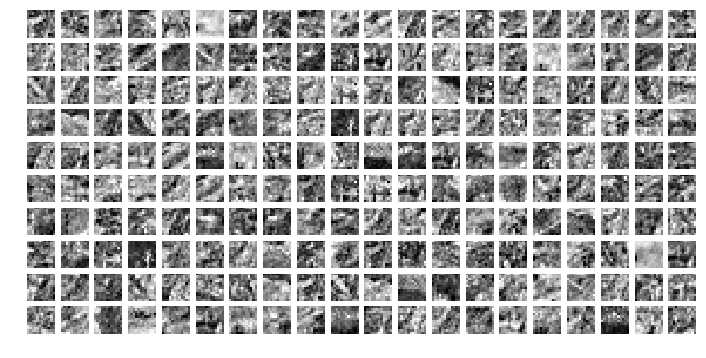

In [48]:
print("After 524 iterations.")
plt.figure(figsize=(12,12))
for i in range(200):
    plt.subplot(20, 20, i + 1)
    plt.imshow(basis_new[:,i].reshape(12,12), cmap='gray')
    plt.axis("off")

After 2524 iterations.


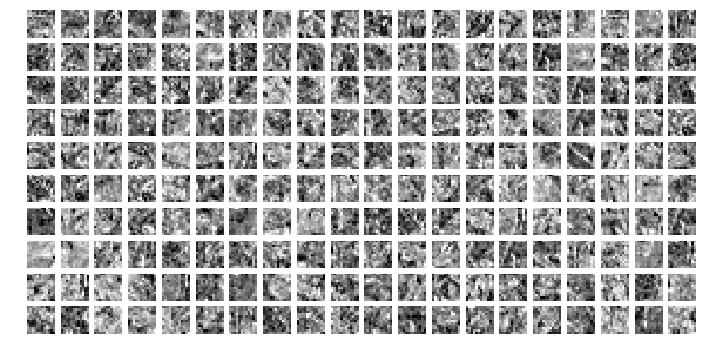

In [49]:
for it in range(2000):
    test_image = images[:,:,random.randint(0,9)]
    patches = sample_random_square_patches(test_image, patch_nums, patch_width)
    flat_patches = [patches[:,:,i].reshape(-1,) for i in range(patches.shape[2])]
    regs = np.array([linear_model.ElasticNet(alpha=0.0005, l1_ratio=1).fit(basis_new, patch) for patch in flat_patches])
    betas = np.array([r.coef_ for r in regs])
    preds = np.array([r.predict(basis_new) for r in regs])
    grad = np.array(preds - np.array(flat_patches)).T.dot(betas)
    basis_new = basis_new - grad * 0.01
    basis_new = normalize(basis_new, norm='l1', axis=0)
    
print("After 2524 iterations.")
plt.figure(figsize=(12,12))
for i in range(200):
    plt.subplot(20, 20, i + 1)
    plt.imshow(basis_new[:,i].reshape(12,12), cmap='gray')
    plt.axis("off")

After 2524 iterations.


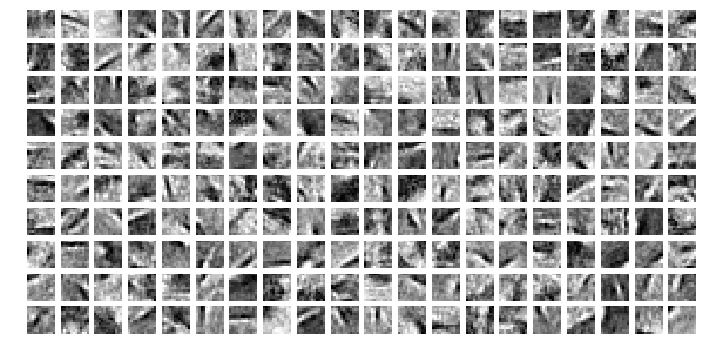

In [50]:
for it in range(2000):
    test_image = images[:,:,random.randint(0,9)]
    patches = sample_random_square_patches(test_image, patch_nums, patch_width)
    flat_patches = [patches[:,:,i].reshape(-1,) for i in range(patches.shape[2])]
    regs = np.array([linear_model.ElasticNet(alpha=0.0005, l1_ratio=1).fit(basis_new, patch) for patch in flat_patches])
    betas = np.array([r.coef_ for r in regs])
    preds = np.array([r.predict(basis_new) for r in regs])
    grad = np.array(preds - np.array(flat_patches)).T.dot(betas)
    basis_new = basis_new - grad * (1.0 / (it+2524)) # What if we move gradient according to step size?
    basis_new = normalize(basis_new, norm='l1', axis=0)
    
print("After 2524 iterations.")
plt.figure(figsize=(12,12))
for i in range(200):
    plt.subplot(20, 20, i + 1)
    plt.imshow(basis_new[:,i].reshape(12,12), cmap='gray')
    plt.axis("off")

YAY! We see some of thse wavelets after several thousands of iterations. :)

## Try with MNIST

In [4]:
mnist_file = "../../project/cmsc25025/mnist/data.json"  #Working directory/file

In [5]:
df = spark.read.json(mnist_file)

In [6]:
df = df.sample(True, 0.1).collect()

In [13]:
from sklearn.utils import resample
x = np.array([[1,2],[3,4],[5,6],[7,8]])
resample(x, n_samples = 2)

array([[1, 2],
       [1, 2]])

In [14]:
def get_sample(df, size):
    replacement = True
    rows = resample(df, n_samples=size)
    subset = []
    for row in rows:
        subset.append(np.array(row.asDict()['features']))
    subset = np.vstack(subset)
    return subset

In [15]:
sample = get_sample(df, 30)

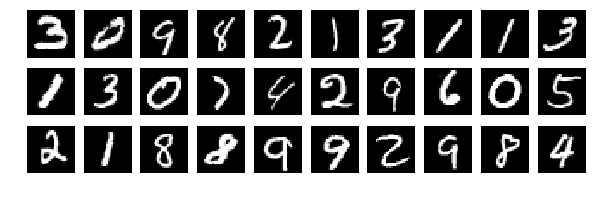

In [19]:
nrows = 3
ncols = 10
plt.figure(figsize=(ncols, nrows))
for i in xrange(nrows*ncols):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(sample[i].reshape((28,28)), cmap='gray')
    plt.axis('off')

plt.axis('off')
plt.show()

In [20]:
# n is the same dimension as the y(i) vectors, so 144
n = sample[0].shape[0]
p = 300 

# Randomly create a matrix 
basis = np.random.rand(n, p)
print(basis.shape)
basis

(784, 300)


array([[ 0.74643431,  0.5077527 ,  0.7159995 , ...,  0.39253092,
         0.86441102,  0.46576918],
       [ 0.64931196,  0.44293322,  0.1149303 , ...,  0.96337374,
         0.79973978,  0.96336769],
       [ 0.92744102,  0.36715483,  0.69543168, ...,  0.24438417,
         0.48081995,  0.20831578],
       ..., 
       [ 0.5930173 ,  0.49433516,  0.99851194, ...,  0.31571643,
         0.74651378,  0.74474718],
       [ 0.20378948,  0.23038193,  0.31978196, ...,  0.6285674 ,
         0.13994242,  0.74192524],
       [ 0.85161296,  0.28406725,  0.12540691, ...,  0.34588599,
         0.22268881,  0.28084918]])

In [21]:
regs = np.array([linear_model.ElasticNet(alpha=0.0001, l1_ratio=1).fit(basis, num) for num in sample])
betas = np.array([r.coef_ for r in regs])
preds = np.array([r.predict(basis) for r in regs])
grad = np.array(preds - np.array(sample)).T.dot(betas)
basis = basis - grad * (1.0 / 1) # What if we move gradient according to step size?
basis = normalize(basis, norm='l1', axis=0)

After 1 iteration.


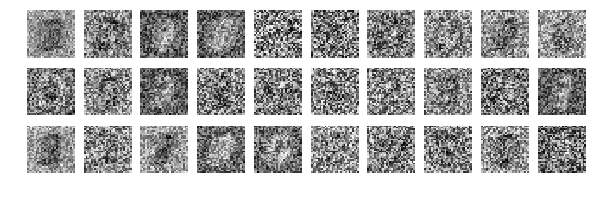

In [22]:
print("After 1 iteration.")
plt.figure(figsize=(ncols,nrows))
for i in range(30):
    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(basis[:,i].reshape(28,28), cmap='gray')
    plt.axis("off")

After 10 iterations.


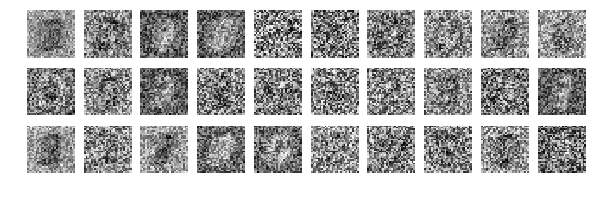

In [23]:
for it in range(10):
    sample = get_sample(df, 30)
    regs = np.array([linear_model.ElasticNet(alpha=0.0001, l1_ratio=1).fit(basis, num) for num in sample])
    betas = np.array([r.coef_ for r in regs])
    preds = np.array([r.predict(basis) for r in regs])
    grad = np.array(preds - np.array(sample)).T.dot(betas)
    basis = basis - grad * (1.0 / (it+1)) # What if we move gradient according to step size?
    basis = normalize(basis, norm='l1', axis=0)

print("After 11 iterations.")
plt.figure(figsize=(ncols,nrows))
for i in range(30):
    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(basis[:,i].reshape(28,28), cmap='gray')
    plt.axis("off")

After 110 iterations.


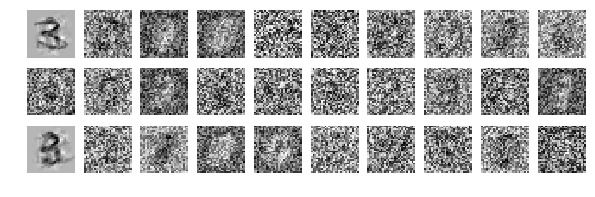

In [26]:
for it in range(100):
    sample = get_sample(df, 30)
    regs = np.array([linear_model.ElasticNet(alpha=0.0001, l1_ratio=1).fit(basis, num) for num in sample])
    betas = np.array([r.coef_ for r in regs])
    preds = np.array([r.predict(basis) for r in regs])
    grad = np.array(preds - np.array(sample)).T.dot(betas)
    basis = basis - grad * (1.0 / (it+11)) # What if we move gradient according to step size?
    basis = normalize(basis, norm='l1', axis=0)

print("After 110 iterations.")
plt.figure(figsize=(ncols,nrows))
for i in range(30):
    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(basis[:,i].reshape(28,28), cmap='gray')
    plt.axis("off")

After 2110 iterations.


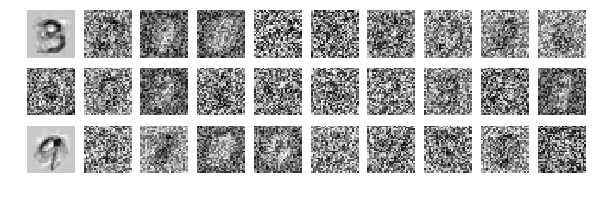

In [27]:
for it in range(2000):
    sample = get_sample(df, 30)
    regs = np.array([linear_model.ElasticNet(alpha=0.0001, l1_ratio=1).fit(basis, num) for num in sample])
    betas = np.array([r.coef_ for r in regs])
    preds = np.array([r.predict(basis) for r in regs])
    grad = np.array(preds - np.array(sample)).T.dot(betas)
    basis = basis - grad * (1.0 / (it+111)) # What if we move gradient according to step size?
    basis = normalize(basis, norm='l1', axis=0)

print("After 2110 iterations.")
plt.figure(figsize=(ncols,nrows))
for i in range(30):
    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(basis[:,i].reshape(28,28), cmap='gray')
    plt.axis("off")

After 4110 iterations.


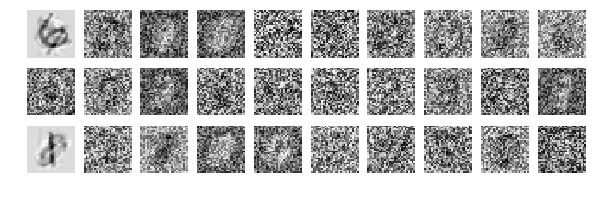

In [28]:
for it in range(2000):
    sample = get_sample(df, 30)
    regs = np.array([linear_model.ElasticNet(alpha=0.0001, l1_ratio=1).fit(basis, num) for num in sample])
    betas = np.array([r.coef_ for r in regs])
    preds = np.array([r.predict(basis) for r in regs])
    grad = np.array(preds - np.array(sample)).T.dot(betas)
    basis = basis - grad * (1.0 / (it+2111)) # What if we move gradient according to step size?
    basis = normalize(basis, norm='l1', axis=0)

print("After 4110 iterations.")
plt.figure(figsize=(ncols,nrows))
for i in range(30):
    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(basis[:,i].reshape(28,28), cmap='gray')
    plt.axis("off")

# Maybe if we increase the number of samples this will work faster?

After 0 iterations.


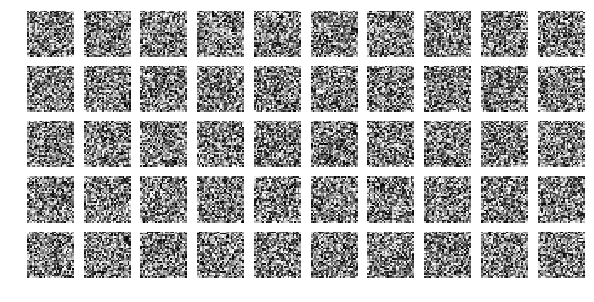

In [58]:
# n is the same dimension as the y(i) vectors, so 144
sample_size = 50
sample = get_sample(df, sample_size)
n = sample[0].shape[0]
p = 300 

# Randomly create a matrix 
basis = np.random.rand(n, p)

j = 0

plt.figure(figsize=(10,10))
for i in range(sample_size):
    plt.subplot(10, 10, i + 1)
    plt.imshow(basis[:,i].reshape(28,28), cmap='gray')
    plt.axis("off")

print("After {} iterations.".format(j))

After 200 iterations.


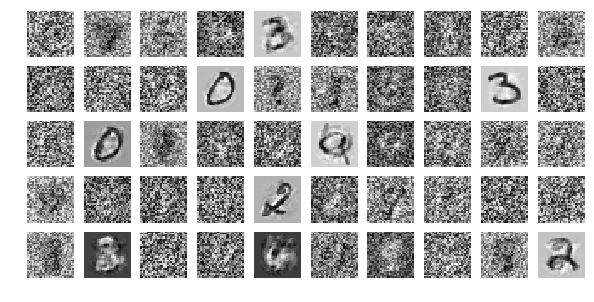

In [59]:
steps = 200
for it in range(steps):
    j += 1
    sample = get_sample(df, sample_size)
    regs = np.array([linear_model.ElasticNet(alpha=0.0001, l1_ratio=1).fit(basis, num) for num in sample])
    betas = np.array([r.coef_ for r in regs])
    preds = np.array([r.predict(basis) for r in regs])
    grad = np.array(preds - np.array(sample)).T.dot(betas)
    basis = basis - grad * (1.0 / (j)) # What if we move gradient according to step size?
    basis = normalize(basis, norm='l1', axis=0)

print("After {} iterations.".format(j))
plt.figure(figsize=(10,10))
for i in range(sample_size):
    plt.subplot(10, 10, i + 1)
    plt.imshow(basis[:,i].reshape(28,28), cmap='gray')
    plt.axis("off")

After 400 iterations.


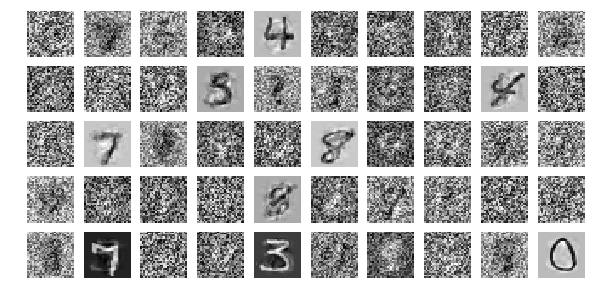

In [60]:
steps = 200
for it in range(steps):
    j += 1
    sample = get_sample(df, sample_size)
    regs = np.array([linear_model.ElasticNet(alpha=0.0001, l1_ratio=1).fit(basis, num) for num in sample])
    betas = np.array([r.coef_ for r in regs])
    preds = np.array([r.predict(basis) for r in regs])
    grad = np.array(preds - np.array(sample)).T.dot(betas)
    basis = basis - grad * (1.0 / (j)) # What if we move gradient according to step size?
    basis = normalize(basis, norm='l1', axis=0)

print("After {} iterations.".format(j))
plt.figure(figsize=(10,10))
for i in range(sample_size):
    plt.subplot(10, 10, i + 1)
    plt.imshow(basis[:,i].reshape(28,28), cmap='gray')
    plt.axis("off")

After 1400 iterations.


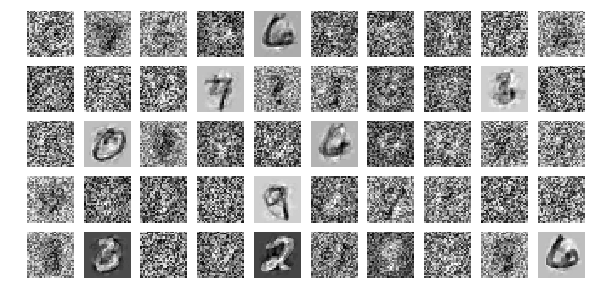

In [61]:
steps = 1000
for it in range(steps):
    j += 1
    sample = get_sample(df, sample_size)
    regs = np.array([linear_model.ElasticNet(alpha=0.0001, l1_ratio=1).fit(basis, num) for num in sample])
    betas = np.array([r.coef_ for r in regs])
    preds = np.array([r.predict(basis) for r in regs])
    grad = np.array(preds - np.array(sample)).T.dot(betas)
    basis = basis - grad * (1.0 / (j)) # What if we move gradient according to step size?
    basis = normalize(basis, norm='l1', axis=0)

print("After {} iterations.".format(j))
plt.figure(figsize=(10,10))
for i in range(sample_size):
    plt.subplot(10, 10, i + 1)
    plt.imshow(basis[:,i].reshape(28,28), cmap='gray')
    plt.axis("off")

After 3400 iterations.


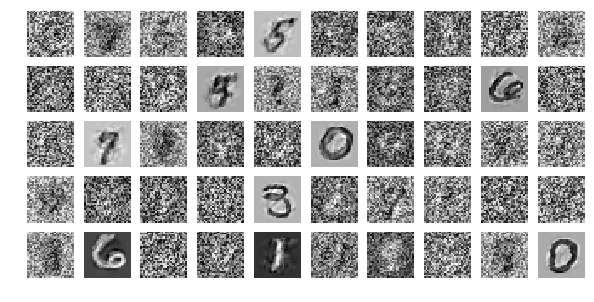

In [62]:
steps = 2000
for it in range(steps):
    j += 1
    sample = get_sample(df, sample_size)
    regs = np.array([linear_model.ElasticNet(alpha=0.0001, l1_ratio=1).fit(basis, num) for num in sample])
    betas = np.array([r.coef_ for r in regs])
    preds = np.array([r.predict(basis) for r in regs])
    grad = np.array(preds - np.array(sample)).T.dot(betas)
    basis = basis - grad * (1.0 / (j)) # What if we move gradient according to step size?
    basis = normalize(basis, norm='l1', axis=0)

print("After {} iterations.".format(j))
plt.figure(figsize=(10,10))
for i in range(sample_size):
    plt.subplot(10, 10, i + 1)
    plt.imshow(basis[:,i].reshape(28,28), cmap='gray')
    plt.axis("off")

Yay! Numbers! :)

### Reconstructed numbers

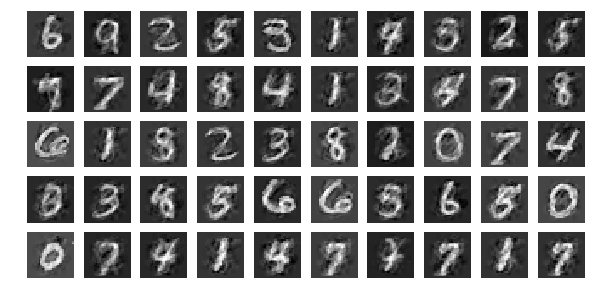

In [72]:
plt.figure(figsize=(10,10))
for i in range(sample_size):
    plt.subplot(10, 10, i + 1)
    plt.imshow(basis.dot(betas.T)[:,i].reshape(28,28), cmap='gray')
    plt.axis("off")

It seems it takes a couple thousands of iterations to get a basis that resembles the numbers. Even with +3400 iterations, there seems to be only a handful of vectors that represent some of the numbers (e.g. 6, 0, 1, 3, 5, 7-ish). Reconstruction is not bad,, but there is quite some blur in the final numbers.